In [2]:
#%gui wx
%matplotlib inline

In [3]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
#from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
from plotting import plot_surf_stat_map
import operator
import time

In [4]:
def make_cmap(c):
    cmap = np.asarray(sns.color_palette('Blues', c-1))
    cmap = np.concatenate((np.array([[0.8,0.8,0.8]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [5]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

### Loading and preparing data

In [6]:
hemi='rh'

mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d.vtk'%hemi
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d_sulc.npy'%hemi
mask_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/%s_fullmask.npy'%hemi
embed_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/connectivity/%s_smooth_3_embed_10.npy'%hemi
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/smooth_3/avg_%s_profiles_smooth_3.npy'%hemi
r1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/smooth_3/avg_%s_r1_smooth_3.npy'%hemi
t1_embed_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/profiles/%s_smooth_3_embedding_10_markov.npy'%hemi

In [7]:
colors = sns.color_palette('cubehelix', 10)

In [8]:
v,f,d = read_vtk(mesh_file)
mask = np.load(mask_file)
embedding = np.load(embed_file)
t1_embedding = np.load(t1_embed_file)
t1_profiles = np.load(t1_file)
r1_profiles = np.load(r1_file)
sulc = np.load(sulc_file)

In [9]:
t1_profiles[mask]=0
r1_profiles[mask]=0

In [10]:
t1_avg = np.mean(t1_profiles[:,3:8], axis=1)
t1_avg_supra = np.mean(t1_profiles[:,6:8], axis=1)
t1_avg_infra = np.mean(t1_profiles[:,3:5], axis=1)

r1_avg = np.mean(r1_profiles[:,3:8], axis=1)
r1_avg_supra = np.mean(r1_profiles[:,6:8], axis=1)
r1_avg_infra = np.mean(r1_profiles[:,3:5], axis=1)

### Plotting Chebychev approximation

#### Some random profiles (green) and their Chebychev approximation (black circles)

#### The same profiles between T1 1500 and 2500 (which will be used)

#### Compare T1 average and zero coefficient

### 2D histogramms

#### Prepare data so that only nodes with T1 between 1500 and 2500 and Embedding != 0 are kept in both arrays

In [11]:
scatter_t1avg = np.delete(t1_avg, mask)
scatter_t1avg_supra = np.delete(t1_avg_supra, mask)
scatter_t1avg_infra = np.delete(t1_avg_infra, mask)

scatter_r1avg = np.delete(r1_avg, mask)
scatter_r1avg_supra = np.delete(r1_avg_supra, mask)
scatter_r1avg_infra = np.delete(r1_avg_infra, mask)
#scatter_coeff = np.delete(coeff, mask, axis=0)
scatter_embed = np.delete(embedding, mask, axis=0)
#scatter_embed_t1 = np.delete(t1_embedding, mask,axis=0)

t1_idx=np.where(scatter_t1avg<=1500)
scatter_t1avg = np.delete(scatter_t1avg, t1_idx)
scatter_t1avg_supra = np.delete(scatter_t1avg_supra, t1_idx)
scatter_t1avg_infra = np.delete(scatter_t1avg_infra, t1_idx)
#scatter_coeff = np.delete(scatter_coeff, t1_idx, axis=0)
#scatter_embed = np.delete(scatter_embed, t1_idx, axis=0)
#scatter_embed_t1 = np.delete(scatter_embed_t1, t1_idx, axis=0)


r1_idx=np.where(scatter_r1avg>(1./1500))
scatter_r1avg = np.delete(scatter_r1avg, r1_idx)
scatter_r1avg_supra = np.delete(scatter_r1avg_supra, r1_idx)
scatter_r1avg_infra = np.delete(scatter_r1avg_infra, r1_idx)
scatter_embed = np.delete(scatter_embed, r1_idx, axis=0)


#t1_idx_2=np.where(t1_avg>=2500)
#scatter_t1avg = np.delete(scatter_t1avg, t1_idx_2)
#scatter_coeff = np.delete(scatter_coeff, t1_idx_2, axis=0)
#scatter_embed = np.delete(scatter_embed, t1_idx_2, axis=0)

#embed_idx=np.where(scatter_embed[:,0]==0)
#scatter_t1avg = np.delete(scatter_t1avg, embed_idx)
#scatter_coeff = np.delete(scatter_coeff, embed_idx, axis=0)
#scatter_embed = np.delete(scatter_embed, embed_idx, axis=0)
#scatter_embed_t1 = np.delete(scatter_embed_t1, embed_idx, axis=0)

#t1_embed_idx=np.where(scatter_embed_t1[:,0]==0)
#scatter_t1avg = np.delete(scatter_t1avg, t1_embed_idx)
#scatter_coeff = np.delete(scatter_coeff, t1_embed_idx, axis=0)
#scatter_embed = np.delete(scatter_embed, t1_embed_idx, axis=0)
#scatter_embed_t1 = np.delete(scatter_embed_t1, t1_embed_idx, axis=0)


#coeff1_idx1=np.where(scatter_coeff[:,1]>200)
#scatter_t1avg = np.delete(scatter_t1avg, coeff1_idx1)
#scatter_coeff = np.delete(scatter_coeff, coeff1_idx1, axis=0)
#scatter_embed = np.delete(scatter_embed, coeff1_idx1, axis=0)

#coeff1_idx2=np.where(scatter_coeff[:,1]<-100)
#scatter_t1avg = np.delete(scatter_t1avg, coeff1_idx2)
#scatter_coeff = np.delete(scatter_coeff, coeff1_idx2, axis=0)
#scatter_embed = np.delete(scatter_embed, coeff1_idx2, axis=0)



#coeff2_idx1=np.where(scatter_coeff[:,2]>75)
#scatter_t1avg = np.delete(scatter_t1avg, coeff2_idx1)
#scatter_coeff = np.delete(scatter_coeff, coeff2_idx1, axis=0)
#scatter_embed = np.delete(scatter_embed, coeff2_idx1, axis=0)

#coeff2_idx2=np.where(scatter_coeff[:,2]<-75)
#scatter_t1avg = np.delete(scatter_t1avg, coeff2_idx2)
#scatter_coeff = np.delete(scatter_coeff, coeff2_idx2, axis=0)
#scatter_embed = np.delete(scatter_embed, coeff2_idx2, axis=0)



#coeff3_idx1=np.where(scatter_coeff[:,3]>20)
#scatter_t1avg = np.delete(scatter_t1avg, coeff3_idx1)
#scatter_coeff = np.delete(scatter_coeff, coeff3_idx1, axis=0)
#scatter_embed = np.delete(scatter_embed, coeff3_idx1, axis=0)

#coeff3_idx2=np.where(scatter_coeff[:,3]<-10)
#scatter_t1avg = np.delete(scatter_t1avg, coeff3_idx2)
#scatter_coeff = np.delete(scatter_coeff, coeff3_idx2, axis=0)
#scatter_embed = np.delete(scatter_embed, coeff3_idx2, axis=0)



#coeff4_idx1=np.where(scatter_coeff[:,4]>1)
#scatter_t1avg = np.delete(scatter_t1avg, coeff4_idx1)
#scatter_coeff = np.delete(scatter_coeff, coeff4_idx1, axis=0)
#scatter_embed = np.delete(scatter_embed, coeff4_idx1, axis=0)

#coeff4_idx2=np.where(scatter_coeff[:,4]<-1)
#scatter_t1avg = np.delete(scatter_t1avg, coeff4_idx2)
#scatter_coeff = np.delete(scatter_coeff, coeff4_idx2, axis=0)
#scatter_embed = np.delete(scatter_embed, coeff4_idx2, axis=0)

In [12]:
sns.set_style('darkgrid')

#### Intracortical avg T1

In [13]:
sns.set_context('notebook', font_scale=1.5)

(array([   194.,   9154.,  18213.,  11427.,  12137.,   6164.,   1074.,
           232.,    138.,     85.]),
 array([ 0.00041898,  0.00044372,  0.00046846,  0.0004932 ,  0.00051794,
         0.00054268,  0.00056742,  0.00059216,  0.0006169 ,  0.00064164,
         0.00066638]),
 <a list of 10 Patch objects>)

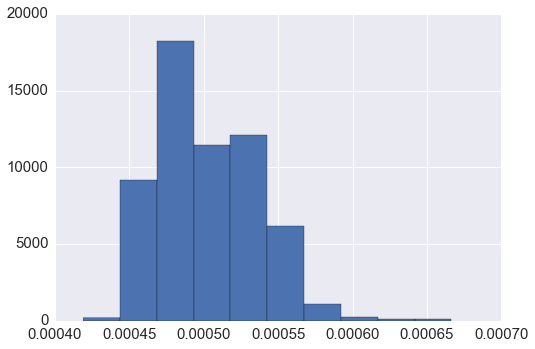

In [14]:
plt.hist(scatter_r1avg)

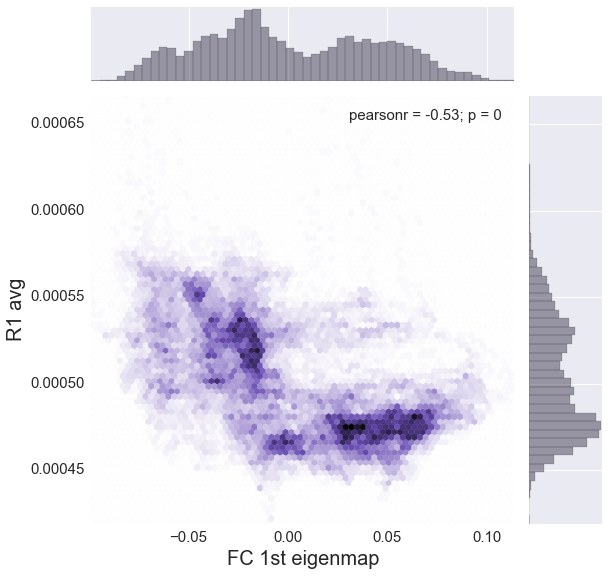

In [15]:
g = sns.jointplot(scatter_embed[:,0], scatter_r1avg, kind="hex", size=8, color=colors[0])
g.set_axis_labels('FC 1st eigenmap', 'R1 avg', fontsize=20)

In [16]:
g.savefig('/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/figs/proper_r1supra_vs_fc2.png')

In [17]:
blob_a=np.where((t1_avg>2000) & (embedding[:,0]<-0.05))[0]

In [80]:
blob_b=np.where((t1_avg>2000) & (embedding[:,0]>-0.05)&(embedding[:,0]<-0.00))[0]

In [81]:
blob_c=np.where((t1_avg>2000) & (embedding[:,0]>-0.0))[0]

In [87]:
blob_d=np.where((t1_avg<2000) & (embedding[:,0]>0.00))[0]

In [88]:
blob_e=np.where((t1_avg<2000) & (embedding[:,0]>0.03))[0]

In [73]:
from plotting import plot_surf_label

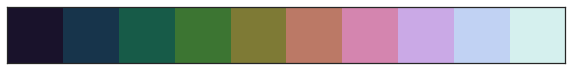

In [86]:
sns.palplot(colors)

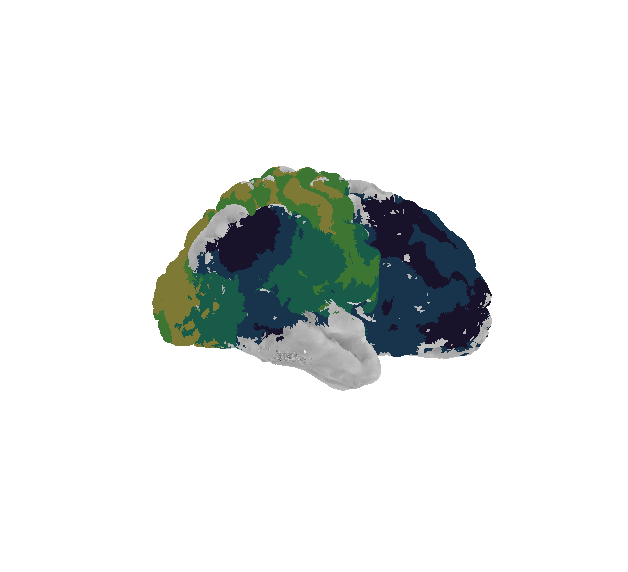

In [89]:
sns.set_style('white')
plot=plot_surf_label(v, f, labels=tuple([blob_a, blob_b, blob_c, blob_d, blob_e]), cpal=colors, 
                     bg_map=sulc, elev=180,azim=0, figsize=(11,10), darkness=0.8)

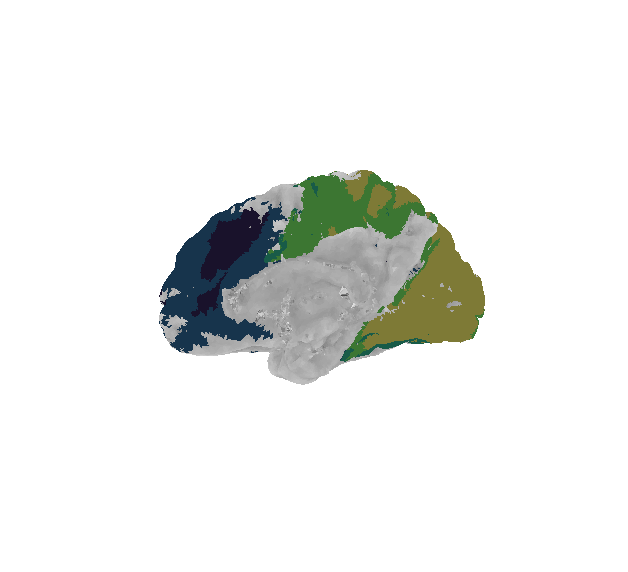

In [90]:
sns.set_style('white')
plot=plot_surf_label(v, f, labels=tuple([blob_a, blob_b, blob_c, blob_d, blob_e]), cpal=colors, 
                     bg_map=sulc, elev=180,azim=180, figsize=(11,10), darkness=0.8)

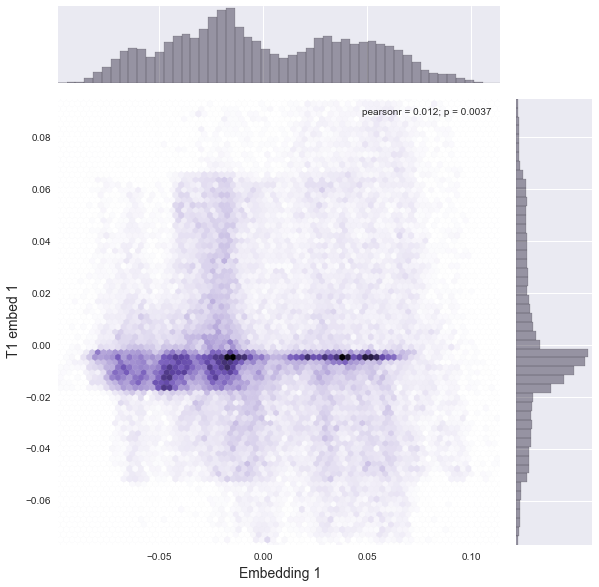

In [88]:
g = sns.jointplot(scatter_embed[:,0], scatter_embed_t1[:,2], kind="hex", size=8, color=colors[0])
g.set_axis_labels('Embedding 1', 'T1 embed 1', fontsize=14)

(-0.001, 0.001)

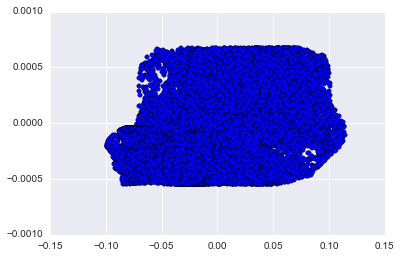

In [82]:
plt.scatter(scatter_embed[:,0], scatter_embed_t1[:,0])
plt.ylim([-0.001, 0.001])

In [80]:
plt.scatter?

In [78]:
sp.stats.spearmanr(scatter_embed[:,0], scatter_embed_t1[:,0])

SpearmanrResult(correlation=0.55392762041448051, pvalue=0.0)

(array([  2209.,   7263.,  10578.,  18463.,   6469.,   4976.,   4285.,
          2384.,   1464.,   1009.]),
 array([-0.06195174, -0.04584633, -0.02974091, -0.01363549,  0.00246992,
         0.01857534,  0.03468075,  0.05078617,  0.06689159,  0.082997  ,
         0.09910242]),
 <a list of 10 Patch objects>)

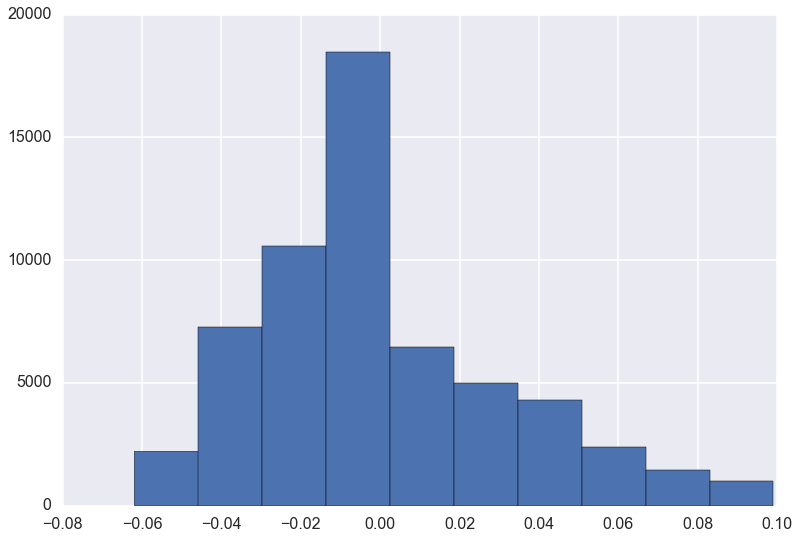

In [32]:
plt.hist(scatter_embed_t1[:,3])

#### Chebychev zero coeffiecient (~mean)

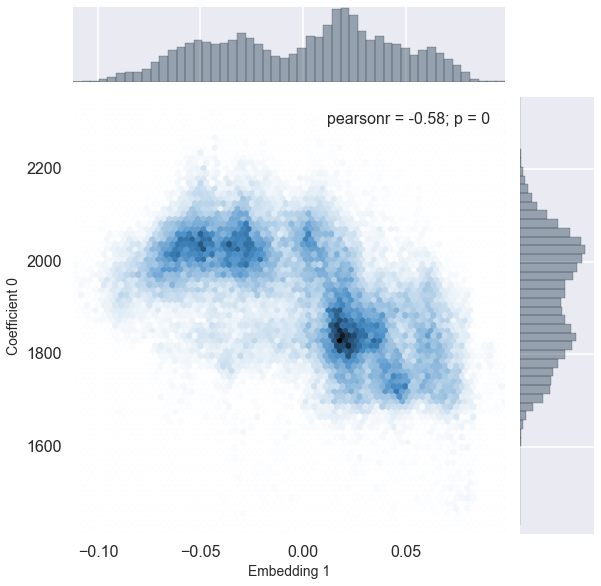

In [19]:
g = sns.jointplot(scatter_embed[:,0], scatter_coeff[:,0], kind="hex", size=8, color=colors[1])
g.set_axis_labels('Embedding 1', 'Coefficient 0', fontsize=14)

#### Chebychev coefficient 1 (~slope)

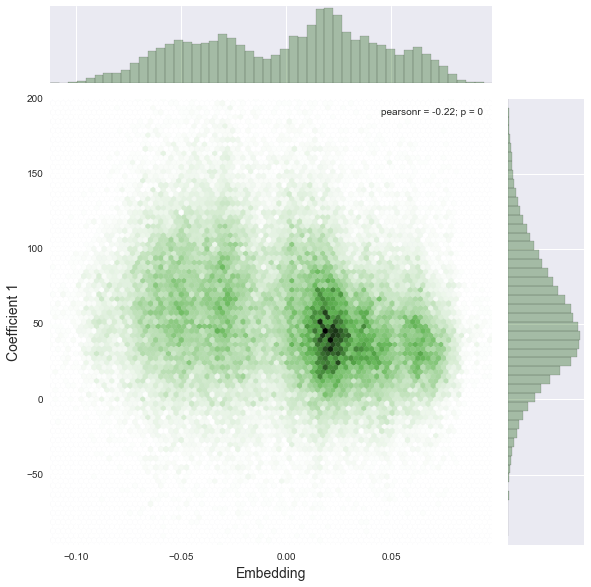

In [51]:
g = sns.jointplot(scatter_embed[:,0], scatter_coeff[:,1], kind="hex", color=colors[3], size=8)
g.set_axis_labels('Embedding', 'Coefficient 1', fontsize=14)

#### Chebychev coefficient 2 (~spread)

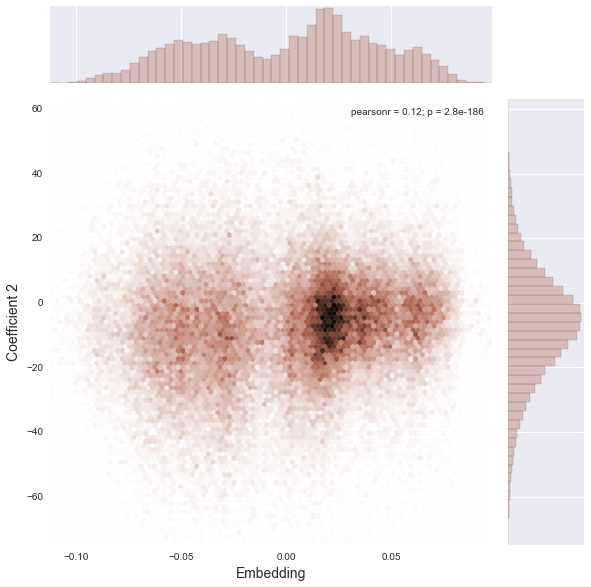

In [52]:
g = sns.jointplot(scatter_embed[:,0], scatter_coeff[:,2], kind="hex", color=colors[5], size=8)
g.set_axis_labels('Embedding', 'Coefficient 2', fontsize=14)

#### Chebychev coefficient 3

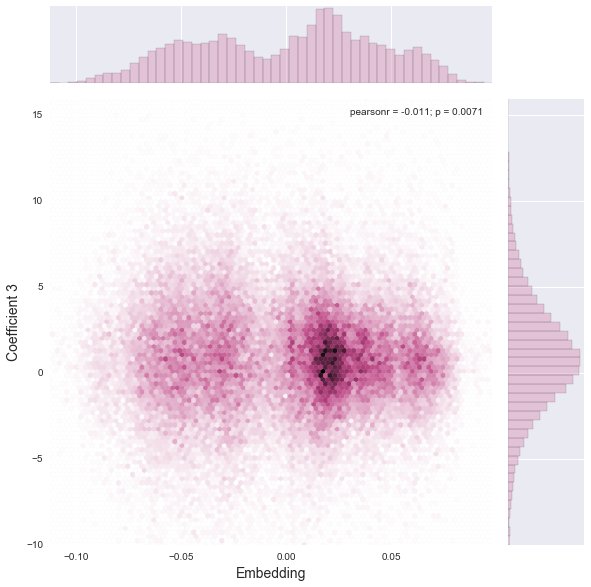

In [53]:
g = sns.jointplot(scatter_embed[:,0], scatter_coeff[:,3], kind="hex", color=colors[6], size=8)
g.set_axis_labels('Embedding', 'Coefficient 3', fontsize=14)

#### Chebychev coefficient 4

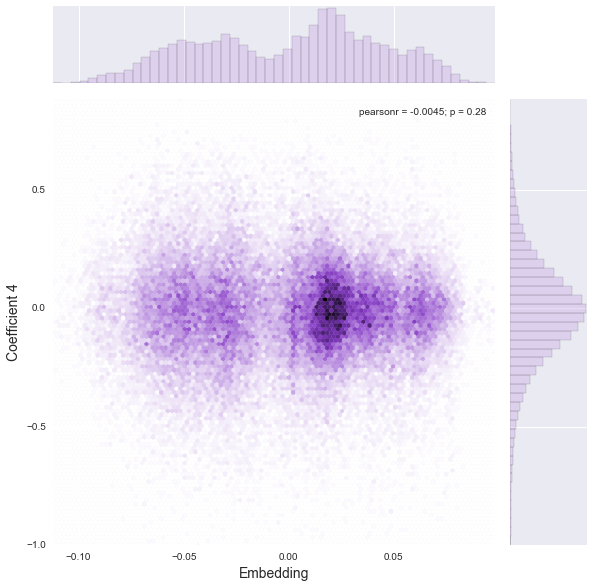

In [54]:
g = sns.jointplot(scatter_embed[:,0], scatter_coeff[:,4], kind="hex", color=colors[7], size=8)
g.set_axis_labels('Embedding', 'Coefficient 4', fontsize=14)

### Brains

In [47]:
sns.set_style('white')

#### 1st Embedding component

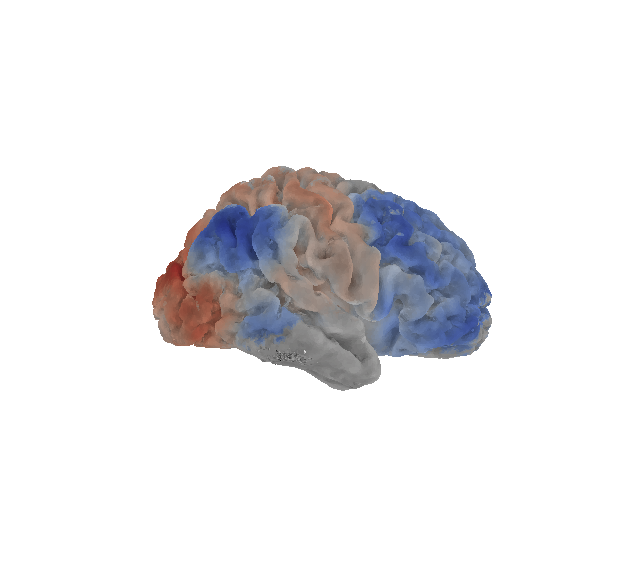

In [24]:
plot=plot_surf_stat_map(v, f, embedding[:,0], elev=180, azim=0, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True)

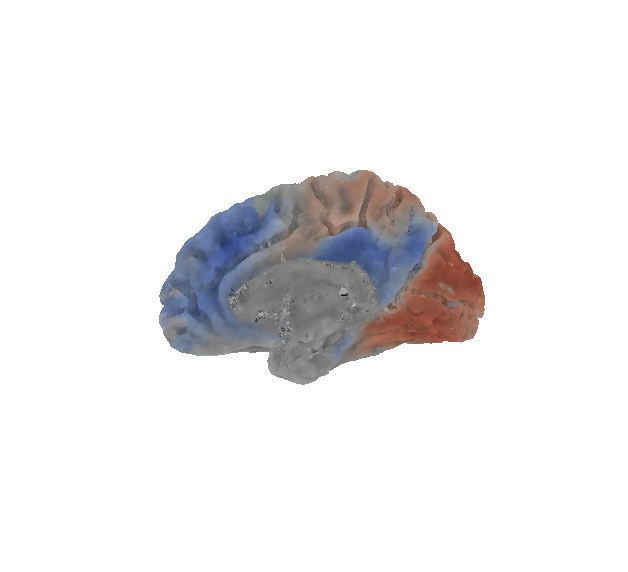

In [25]:
plot=plot_surf_stat_map(v, f, embedding[:,0], elev=180, azim=180, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True)

#### Intracortical avg T1, thresholded and brought down to avg zero

In [26]:
t1_avg_brain = t1_avg.copy()
t1_avg_brain[np.where(t1_avg<1500)]=1500
t1_avg_brain[np.where(t1_avg>2500)]=2500
t1_avg_brain -= np.mean(t1_avg_brain)
t1_avg_brain[mask] = 0

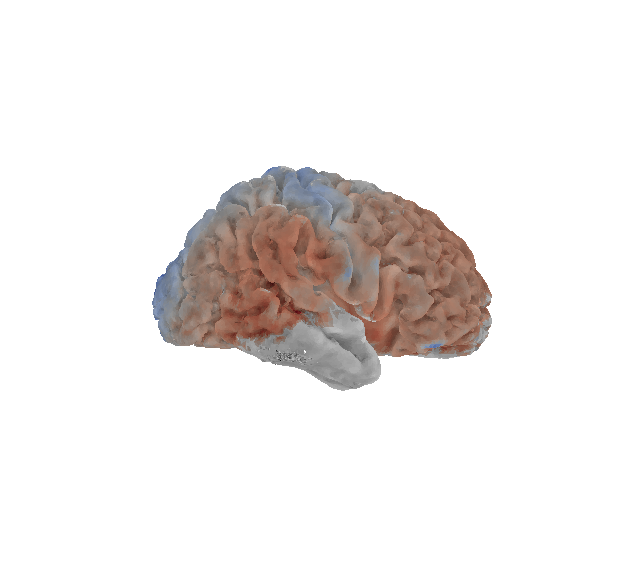

In [27]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, t1_avg_brain, elev=180, azim=0, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)

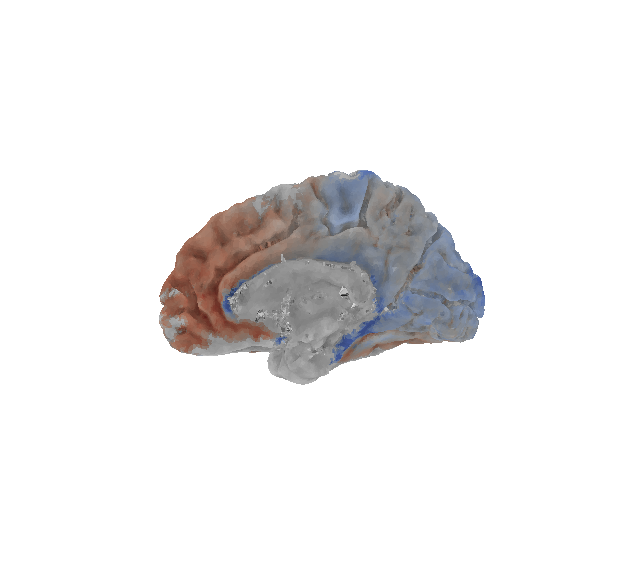

In [28]:
plot=plot_surf_stat_map(v, f, t1_avg_brain, elev=180, azim=180, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)

#### Chebychev coefficient zero, thresholded and brought down to avg zero

In [29]:
coeff0_brain = coeff[:,0].copy()
coeff0_brain[np.where(coeff0_brain<1500)]=1500
coeff0_brain[np.where(coeff0_brain>2500)]=2500
coeff0_brain -= np.mean(coeff0_brain)
coeff0_brain[mask] = 0

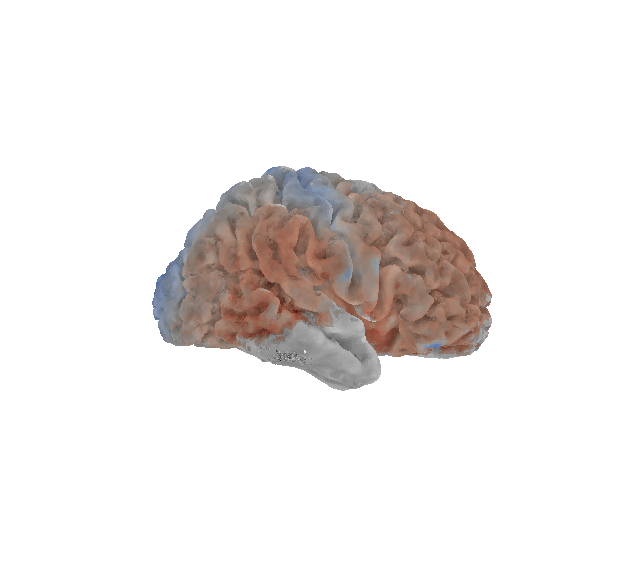

In [30]:
plot=plot_surf_stat_map(v, f, coeff0_brain, elev=180, azim=0, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)

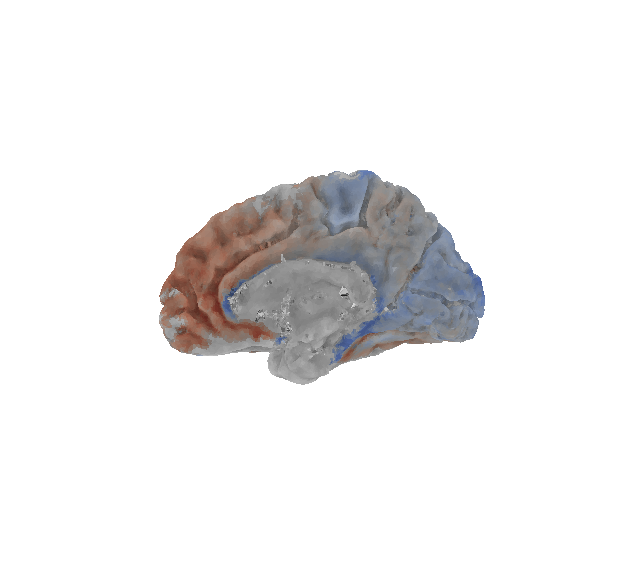

In [31]:
plot=plot_surf_stat_map(v, f, coeff0_brain, elev=180, azim=180, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)

#### Chebychev coefficient 1, thresholded and brought to mean zero

In [50]:
coeff1_brain = coeff[:,1].copy()
coeff1_brain[np.where(coeff1_brain<-100)]=-100
coeff1_brain[np.where(coeff1_brain>200)]=200
coeff1_brain -= np.mean(coeff1_brain)
coeff1_brain[mask] = 0

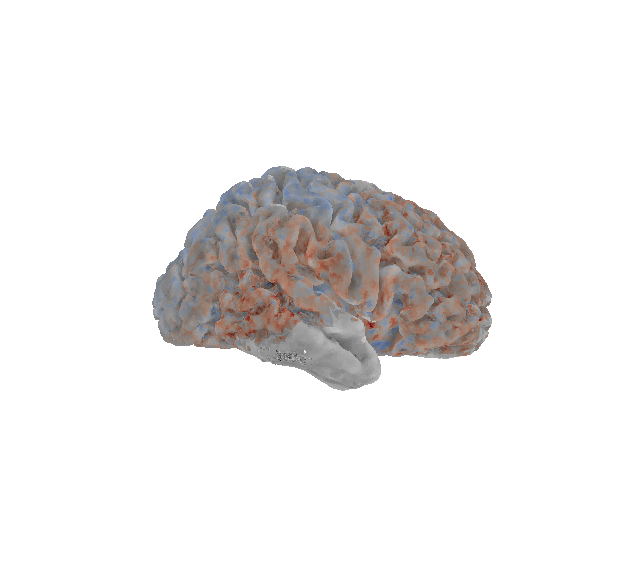

In [51]:
plot=plot_surf_stat_map(v, f, coeff1_brain, elev=180, azim=0, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)

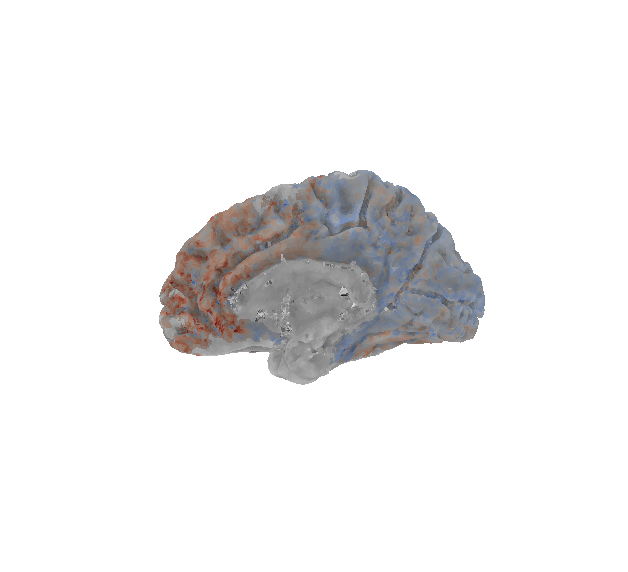

In [52]:
plot=plot_surf_stat_map(v, f, coeff1_brain, elev=180, azim=180, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)